<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<font color="#138D75">**WEkEO Training**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Anna-Lena Erdmann (EUMETSAT)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4data/wekeo-eocanvas/01_Introduction_to_EOCanvas.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg?style=flat&logo=" alt="Open in WEkEO"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>    
</html>

<div class="alert alert-block alert-success">
<h3> WEkEO EOCanvas - Processing in the Cloud for Coperncius Data</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
  - **<a href="https://my.wekeo.eu/user-registration" target="_blank">A WEkEO account</a>**
  

</div>
<hr>

# 1 An Introduction to the EOCanvas

### Learning outcomes

At the end of this notebook you will know;

* what the EOCanvas service of WEkEO is
* how to build your own SNAP process in the EOCanvas
* how to subset a Sentinel-3 OLCI satellite image using the EOCanvas


### Outline

The The EOCanvas is a WEkEO service to process Coperncius data in the Cloud. This notebooks gives an introduction of the service and how a process is built up and executed. You will use the software package SNAP to make a spatial subset of a Senitnel-3 tile within the cloud and only download the result of the process. 

<div class="alert alert-info" role="alert">

### Contents <a id='totop'></a>

</div>
    
 1. [Introduction to EOCanvas](#section0)
 2. [Setting Up](#section1)
 3. [Inputs to the EOCanvas Process](#section2)
 4. [Executing the Process](#section3)
 5. [Examine the results](#section4)

<hr>

<div class="alert alert-info" role="alert">

## 1. <a id='section0'></a>Introduction to the EOCanvas
[Back to top](#totop)
    
</div>

**In short:  What is the WEkEO EOCanvas?**

WEkEO EOCanvas is a service to bring serverless processing for all Copernicus data to users. The EOCanvas python module or API enables users to process and analyse data without downloading any files to the local directory. In general, all data, which is available though the <a href='https://www.wekeo.eu/docs/harmonised-data-access-api' target='_blank'>Harmonised Data Access (HDA) API</a> can be processed throu the EOCanvas service. The processes are executed on the cloud, so that only the final result is downloaded to the local directory. 

**In short: Which processes are available?**

The EOCanvas is made for the work with Earth Observation data. Therefore, EOCanvas relies on specialized Earth Observation data analysis software which is already used in the user community to bring the processes to users. 

Currently, there are two software packages inplemented in the EOCanvas: 

- <a href='https://step.esa.int/main/toolboxes/snap/' target='_blank'>SeNtinel Application Platform SNAP</a> 
- <a href='https://user.eumetsat.int/resources/user-guides/data-tailor-standalone-guide' target='_blank'>EUMETSAT Data Tailor</a>

Any process you can perform within the software can also be applied within the EOCanvas. Existing workflows from projects using the software can be easily converted to a serverless workflow by simply proviting the SNAP graph or configutation file to the EOCanvas API. 

<div class="alert alert-info" role="alert">

## 2. <a id='section1'></a>Setting Up

[Back to top](#totop)
    
</div>

Load necessary modules:

In [1]:
from eocanvas import API, Credentials
from eocanvas.api import Input, Config, ConfigOption
from eocanvas.processes import SnapProcess
from eocanvas.snap.graph import Graph

You must replace `<your_user_name>` and `<your_password>` with the information from your WEkEO account (if you don't have one yet, register <a href="https://www.wekeo.eu/" target="_blank">here</a>.

Save your credentials. They will be automatically loaded when required.

In [2]:
c = Credentials(username="<your_user_name>", password="<your_password>")
c.save()

Credentials are written to file C:\Users\erdmann\.hdarc


<div class="alert alert-info" role="alert">

## 3. <a id='section2'></a>Inputs to the EOCanvas Process
[Back to top](#totop)
    
</div>



To process data using the EOCAnvas Serverless Functions, there are **three necessary inputs** to provide to the function:

 1. Data
 2. Processing Workflow
 3. Configuration Parameters

 Let's take a look at each of the inputs using the simple example:
 
 We want to use the serverless function to creating a subset of a Senitnel-3 WFR tile ("1") over a small area of interest over the Baltic Sea ("2"). 

<img src='./img/01_Introduction_Subset_S3.png' alt='' align='centre' width='30%'></img>

### 3.1 Data 

The data is given to the serverless function as an **url**. The url is the reference location of the data in the WEkEO HDA. 

To get the url, you need to make a **request for the data using the WEkEO HDA**.

In [2]:
from hda import Client

c= Client()

q = {
    "dataset_id": "EO:EUM:DAT:SENTINEL-3:OL_2_WFR___",
    "dtstart": "2024-08-06T08:58:00.000Z",
    "dtend": "2024-08-06T09:00:00.000Z",
    "timeliness": "NT"
}

r = c.search(q)
url = r.get_download_urls()[0]
inputs = Input(key="img1", url=url)

The `url` is the first input to the serverless function. 

### 3.2 Processing Workflow

The serverless functions take **workflows coming from common Earth observation data software as input, e.g. the software SNAP**. 

You can build processing workflows using the **SNAP desktop software**. The graphs will look like this in the Graphical User Interface. You can also view the **xml graph** of the processing workflow. The xml graph is then the input to the serverless functions. 

<img src='./img/01_Introduction_SNAP_Graph_Subset.png' alt='' align='centre' width='40%'></img>
<img src='./img/01_Introduction_SNAP_xmlGraph_Subset.png' alt='' align='centre' width='20%'></img>

You can find the xml Graph for subsetting the area of interest in the file `subset_olci.xml`. Let's now import the file as Graph input. 

In [3]:
graph = Graph.from_uri("input_graphs/subset_olci.xml")

### 3.3 Configuration Parameters

Depending on how the data input looks like, there are several preprocessing steps necessary, e.g. unzipping. This is defined in the `Config` input to the serverless functions. 

In [4]:
config = Config(key="img1", options=ConfigOption(uncompress=True, sub_path="xfdumanifest.xml"))

<div class="alert alert-info" role="alert">

## 4. <a id='section3'></a>Execution of the Process
[Back to top](#totop)
    
</div>

Now everything is in place to launch the serverless function and run the process. 

In [5]:
process = SnapProcess(snap_graph=graph, eo_config=config, eo_input=inputs)

In [6]:
process.prepare_inputs()

{'inputs': {'snap_graph': 'PGdyYXBoIGlkPSJHcmFwaCI+CiAgPHZlcnNpb24+MS4wPC92ZXJzaW9uPgogIDxub2RlIGlkPSJSZWFkIj4KICAgIDxvcGVyYXRvcj5SZWFkPC9vcGVyYXRvcj4KICAgIDxzb3VyY2VzLz4KICAgIDxwYXJhbWV0ZXJzIGNsYXNzPSJjb20uYmMuY2VyZXMuYmluZGluZy5kb20uWHBwRG9tRWxlbWVudCI+CiAgICAgIDx1c2VBZHZhbmNlZE9wdGlvbnM+ZmFsc2U8L3VzZUFkdmFuY2VkT3B0aW9ucz4KICAgICAgPGZpbGU+JGltZzE8L2ZpbGU+CiAgICAgIDxjb3B5TWV0YWRhdGE+dHJ1ZTwvY29weU1ldGFkYXRhPgogICAgICA8YmFuZE5hbWVzLz4KICAgICAgPHBpeGVsUmVnaW9uPjAsMCw0ODY1LDQwOTE8L3BpeGVsUmVnaW9uPgogICAgICA8bWFza05hbWVzLz4KICAgIDwvcGFyYW1ldGVycz4KICA8L25vZGU+CiAgPG5vZGUgaWQ9IlN1YnNldCI+CiAgICA8b3BlcmF0b3I+U3Vic2V0PC9vcGVyYXRvcj4KICAgIDxzb3VyY2VzPgogICAgICA8c291cmNlUHJvZHVjdCByZWZpZD0iUmVhZCIvPgogICAgPC9zb3VyY2VzPgogICAgPHBhcmFtZXRlcnMgY2xhc3M9ImNvbS5iYy5jZXJlcy5iaW5kaW5nLmRvbS5YcHBEb21FbGVtZW50Ij4KICAgICAgPHNvdXJjZUJhbmRzPkNITF9OTixDSExfTk5fdW5jLENITF9PQzRNRSxDSExfT0M0TUVfdW5jLGxhdGl0dWRlLGxvbmdpdHVkZTwvc291cmNlQmFuZHM+CiAgICAgIDx0aWVQb2ludEdyaWRzLz4KICAgICAgPHJlZ2lvbj4wLDAsMCwwPC9yZWdpb

Calling Process.run, the process will be submitted. You can set the directory in which the results should be downloaded using `download_dir`. 

It will block until the results have been downloaded. Depending on the process, this can take a while. 

In [7]:
process.run(download_dir="result")

Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: accepted at 2024-10-21T10:59:05.778442
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T10:59:16.291469
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T10:59:27.825847
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T10:59:40.743590
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T10:59:54.600702
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T11:00:09.794172
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T11:00:26.498304
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T11:00:45.019567
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T11:01:06.315133
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T11:01:29.908011
Job: 8ed2fabf-bbc2-5974-a7f9-cf0d581a04ae - Status: running at 2024-10-21T11:01:54.153116


<div class="alert alert-info" role="alert">

## 5. <a id='section4'></a>Examine the result
[Back to top](#totop)
    
</div>

The result is stored in the directory and can be examined using common python tools, such as xarray. 

In [10]:
import os
result = "result//03bd2252-8f8b-11ef-be47-7ac907622680.nc"
result

'result//03bd2252-8f8b-11ef-be47-7ac907622680.nc'

c:\Users\erdmann\AppData\Local\Programs\Python\Python311\Lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


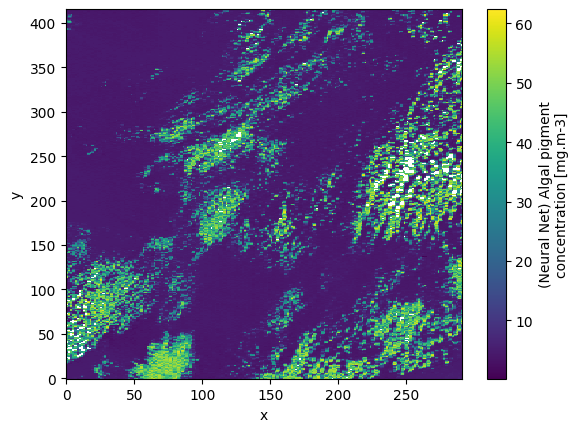

In [11]:
import xarray as xr

xr.open_dataset(result).CHL_NN.plot()

You have just successfully subsetted a Sentinel-3 scene using the WEkEO EOCancas serverless functions. The next tutorial will give you a better understanding of the API, introducing more practical features, such as receiving log files, monitoring your process status and manually triggering the download of the result after successful job execution. 